In [1]:
import os
import pandas as pd
import numpy as np

import librosa
import wave

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.functional as FA
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Audio

In [2]:
PATH_DATASET_DIR = "dataset/en"

# 1. Анализ и разбиение данных 

In [371]:
raw_df_train = pd.read_csv(os.path.join(PATH_DATASET_DIR, "train.tsv"), sep='\t')
raw_df_test = pd.read_csv(os.path.join(PATH_DATASET_DIR, "test.tsv"), sep='\t')
raw_df_val = pd.read_csv(os.path.join(PATH_DATASET_DIR, "validated.tsv"), sep='\t')

raw_df = pd.concat([raw_df_train, raw_df_test, raw_df_val]) \
    .drop_duplicates() \
    .groupby("client_id") \
    .filter(lambda x: len(x) >= 20) \
    .reset_index(drop=True)

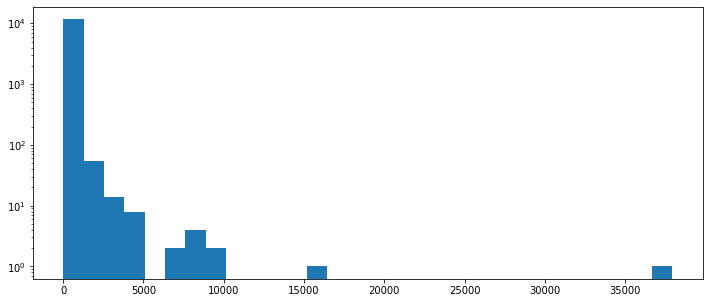

In [372]:
count_data_for_client = raw_df.groupby("client_id").size()

fig = plt.figure(figsize=(12, 5))
plt.hist(count_data_for_client, bins=30)
plt.yscale("log")

In [3]:
def train_test_split(raw_df, split_treshold = 100):
    train_df = raw_df.groupby("client_id").filter(lambda x: len(x) >= split_treshold)
    test_df = raw_df.groupby("client_id").filter(lambda x: len(x) < split_treshold)
    
    return train_df, test_df

In [374]:
train_df, test_df = train_test_split(raw_df)

In [375]:
train_df.to_csv(os.path.join(PATH_DATASET_DIR, "train_biometry.tsv"), sep='\t')
test_df.to_csv(os.path.join(PATH_DATASET_DIR, "test_biometry.tsv"), sep='\t')

#  2. Создание датасета и моделей

In [53]:
class CommonVoiceBiometryDataset(Dataset):
    """
    Create a Dataset CommonVoice for biometry.
    """
    _ext_txt = ".txt"
    _ext_audio = ".mp3"
    _folder_audio = "clips"
    
    def __init__(self, 
                 root, 
                 tsv, 
                 people_treshold = 100, 
                 count_samples = 50, 
                 waveform_treshold = 200000):
        super().__init__()
        
        self._path = os.fspath(root)
        self._tsv = os.path.join(self._path, tsv)
        self._count_samples = count_samples
        
        self._df = pd.read_csv(self._tsv, sep='\t', low_memory=False) \
            .groupby("client_id") \
            .filter(lambda x: len(x) >= people_treshold) \
            .reset_index(drop=True)
        
        self._clients_id = self._df["client_id"].unique()
        self._resample_rate = 32000
        self._waveform_treshold = waveform_treshold
        
    def __getitem__(self, n):
        current_client_id = self._clients_id[n]
        client_df = self._df[self._df["client_id"] == current_client_id] \
            .sample(n=self._count_samples)
        
        waveforms = [] 

        for fileid in client_df["path"]:
            filename = os.path.join(self._path, self._folder_audio, fileid)
        
            if not filename.endswith(self._ext_audio):
                filename += self._ext_audio
            
            waveform, sample_rate = torchaudio.load(filename)
            
            resampled_waveform = FA.resample(waveform, 
                                             sample_rate, 
                                             self._resample_rate)
            
            if resampled_waveform.shape[1] >= self._waveform_treshold:
                resampled_waveform = resampled_waveform[:, :self._waveform_treshold]
            else:
                resampled_waveform = F.pad(
                    resampled_waveform, 
                    (0, self._waveform_treshold - resampled_waveform.shape[1], 0, 0)
                )
            
            
            waveforms.append(resampled_waveform)

        return waveforms, current_client_id
    
    def __len__(self):
        return len(self._clients_id)

In [361]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 lstm_hidden_size, 
                 lstm_num_layers):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, 
                    num_layers=lstm_num_layers, batch_first=True)
        )
        
    def forward(self, x):
        return self.net(x)[:, -1]

In [ ]:
class Discriminator(nn.Module):
    def __init__(self)

In [ ]:
class SimpleModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.encoder = Encoder(input_size=, 
                               output_size=, 
                               lstm_hidden_size=768, 
                               lstm_num_layers=3)
        
        self.discriminator = nn.CosineSimilarity(dim=2)
        
        self.true_d_vector = None
    
    def set_true_d_vector(self, x):
        y = self.encoder(x)
        self.true_d_vector = np.mean(y, dim=0)
    
    def forward(self, x):
        assert self.true_d_vector != None
        
        y = self.encoder(x)
        
        return self.discriminator(y, self.true_d_vector)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        waveforms, clients_id = train_batch
        
        true_waveforms = waveforms[0][:5]
        true_client_id = clients_id[0]
    
        
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)

In [ ]:
class SincConv(nn.Module):
    """
    Sinc-convolution 
    """
    def __init__(self, 
                 out_channels, 
                 kernel_size, 
                 sample_rate=16000, 
                 min_low_hz=50, 
                 min_band_hz=50, 
                 stride=1, 
                 padding=0, 
                 dilation=1,
                 padding_mode='zeros',
                 device=None,
                 dtype=None):
        super(SincConv, self).__init__()
        

In [54]:
train = CommonVoiceBiometryDataset(PATH_DATASET_DIR, 
                                   "train_biometry.tsv", 
                                   people_treshold = 100)

test = CommonVoiceBiometryDataset(PATH_DATASET_DIR, 
                                  "test_biometry.tsv", 
                                  people_treshold = 20,
                                  count_samples = 20)

# 3. Обучение и тестирование

In [388]:
def foo(wfs):
    ll = []
    
    for wf in wfs:
        ll.append(wf.shape[1])
        
        
    return ll

In [390]:
from joblib import Parallel, delayed


l = []

l = Parallel(n_jobs=10)(delayed(foo)(wfs) for wfs,_ in tqdm(train))

  0%|          | 0/2294 [00:00<?, ?it/s]

In [398]:
na = np.array(l).reshape(-1)

np.percentile(na, q=80)

198144.0

In [399]:
pna = na[na < 198144]

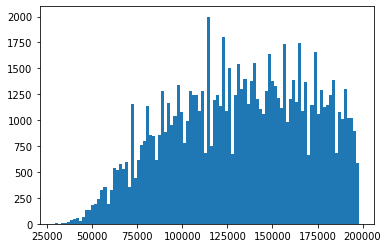

In [400]:
plt.hist(pna, bins=100);

In [ ]:
def collate_fn(batch):
    waveforms_batch = []
    client_id_batch = []
    
    for data in batch:
        waveforms_batch.append(data[0])
        client_id_batch.append(data[1])
        
    img_batch = torch.stack(img_batch)
    in_seqs_batch = torch.stack(in_seqs_batch)
    len_in_seqs_batch = torch.stack(len_in_seqs_batch)

    return img_batch, in_seqs_batch, len_in_seqs_batch

# 4. API

In [58]:
import pyaudio
import wave

In [70]:
p = pyaudio.PyAudio()

for i in range(p.get_device_count()):
    print(i, p.get_device_info_by_index(i)['name'])

0 HDA NVidia: HDMI 0 (hw:0,3)
1 HDA NVidia: HDMI 1 (hw:0,7)
2 HDA NVidia: HDMI 2 (hw:0,8)
3 HDA NVidia: HDMI 3 (hw:0,9)
4 HDA NVidia: HDMI 4 (hw:0,10)
5 HDA NVidia: HDMI 5 (hw:0,11)
6 HDA NVidia: HDMI 6 (hw:0,12)
7 HD-Audio Generic: ALC892 Analog (hw:1,0)
8 HD-Audio Generic: ALC892 Alt Analog (hw:1,2)
9 hdmi
10 pulse
11 default


ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave


In [71]:
CHUNK = 1024
FRT = pyaudio.paInt16
CHAN = 1
RT = 44100
REC_SEC = 5
OUTPUT = "output.wav"

In [72]:
stream = p.open(format=FRT, 
                channels=CHAN, 
                rate=RT, 
                input=True, 
                frames_per_buffer=CHUNK)
print("rec")

frames = []

for i in range(0, int(RT / CHUNK * REC_SEC)):
    data = stream.read(CHUNK)
    frames.append(data)
    
print("done")
 
stream.stop_stream()
stream.close()
p.terminate()

rec
done


In [73]:
PATH_REC_DIR = "tmp"

In [74]:
w = wave.open(os.path.join(PATH_REC_DIR, OUTPUT), 'wb')
w.setnchannels(CHAN)
w.setsampwidth(p.get_sample_size(FRT))
w.setframerate(RT)
w.writeframes(b''.join(frames))
w.close()

In [75]:
display(Audio(os.path.join(PATH_REC_DIR, OUTPUT)))

In [352]:
class AudioRecoder:
    def __init__(self, channels = 1, chunk = 1024, rate = 44100):
        self._format = pyaudio.paFloat32
        self._channels = channels
        self._rate = rate
        self._chunk = chunk
        self._p = None
        self._stream = None
        
    def start(self):
        self._p = pyaudio.PyAudio()
        self._stream = self._p.open(format=self._format,
                                    channels=self._channels,
                                    rate=self._rate,
                                    input=True,
                                    output=False,
                                    stream_callback=self.callback,
                                    frames_per_buffer=self._chunk)
        
    def stop(self):
        self._stream.close()
        self._p.terminate()

    def callback(self, in_data, frame_count, time_info, flag):
        data = np.frombuffer(in_data, dtype=np.float32)
        return data, pyaudio.paContinue

    def mainloop(self):
        while (self._stream.is_active()):
            time.sleep(2.0)


In [353]:
audio_recoder = AudioRecoder()

In [ ]:
audio_recoder.start()
audio_recoder.mainloop()
audio_recoder.stop()